<a href="https://colab.research.google.com/github/NicolasDenier/Handwriting-recognition/blob/main/Handwriting_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [146]:
import matplotlib.pyplot as plt
from matplotlib import image
import numpy as np
import pandas as pd 
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Reshape, Dropout, RandomRotation, RandomZoom, GaussianNoise

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
!ls 'drive/MyDrive/OCR-data'

characters


In [13]:
# Metadata: label and path of each image
characters_data_url = "drive/MyDrive/OCR-data/characters/" #"drive/My Drive/Colab Notebooks/OCR-data/characters/"
characters = pd.read_csv(characters_data_url + "english.csv")
characters.head()

,image,label
0,Img/img001-001.png,0
1,Img/img001-002.png,0
2,Img/img001-003.png,0
3,Img/img001-004.png,0
4,Img/img001-005.png,0


(900, 1200, 3)


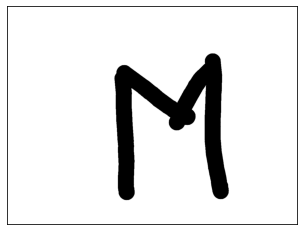

In [14]:
# Show a single image to have an idea of the data
img = image.imread(characters_data_url+characters['image'][1234])
print(img.shape)
plt.tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
plt.imshow(img)
plt.show()

In [15]:
print(np.min(img), np.max(img))

0.0 1.0


In [16]:
# Number of images in a batch
batch_size = 64
# The desired image size
img_height = 90
img_width = 120
SEED=22

In [17]:
classes = characters['label'].unique() # list of classes
num_classes=len(characters['label'].unique()) # number of classes (10 diits + 26 lowercase + 26 uppercase = 62)
label_to_int = {classes[i]:i for i in range(num_classes)} # dict to get an unique id as int for each class
int_to_label = {value:key for key, value in label_to_int.items()} # dict to get back a string label from an int
labels = [label_to_int[l] for l in characters['label']] # list of labels as int

In [18]:
# Prepare the data stream batches (it avoids to overload the RAM)
train_ds = tf.keras.utils.image_dataset_from_directory(
    characters_data_url,
    labels = labels,
    batch_size = batch_size,
    image_size = (img_height, img_width),
    color_mode = 'grayscale',
    seed=SEED,
    validation_split = 0.2,
    shuffle=True,
    subset = "training"
    )

# For some reason the labels are definitely shuffled and need to be redefined
labels = [label_to_int[l] for l in characters['label']]

val_ds = tf.keras.utils.image_dataset_from_directory(
    characters_data_url,
    labels = labels,
    batch_size = batch_size,
    image_size = (img_height, img_width),
    color_mode = 'grayscale',
    seed=SEED,
    validation_split = 0.2,
    shuffle=True,
    subset = "validation"
    )


Found 3410 files belonging to 1 classes.
Using 2728 files for training.
Found 3410 files belonging to 1 classes.
Using 682 files for validation.


(64, 90, 120, 1)
(64,)


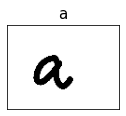

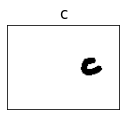

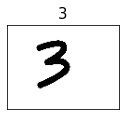

In [99]:
# Check that the labels are correct
def plot_char(image, title):
  plt.figure(figsize=(2, 2))
  plt.imshow(np.reshape(image,(img_height, img_width)), cmap="gray")
  #plt.axis('off')
  plt.tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
  plt.title(title, fontsize=15)
  plt.show()

for image, label in val_ds:
    print(image.shape)
    print(label.shape)
    for i in range(3):
      title=int_to_label[label.numpy()[i]]
      plot_char(image[i], title)
    break

In [20]:
# Better memory performances
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000, seed=SEED).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## First model

In [21]:
img_shape = (img_height, img_width, 1)

# define model
model1 = Sequential([
    Conv2D(16, padding='same', kernel_size=(3,3), activation='relu', input_shape=img_shape),
    MaxPooling2D(padding='same'),
    Conv2D(32, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(),
    Conv2D(64, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

In [22]:
# compile
learning_rate = 1e-3
model1.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
  )

In [23]:
# fit
MODEL_NAME = 'base_model'
logs = {}
EPOCHS = 10
logs[MODEL_NAME] = model1.fit(
    train_ds,
    validation_data = val_ds,
    epochs = EPOCHS,
)

Epoch 1/10
43/43 [==============================] - 35s 148ms/step - loss: 12.1702 - accuracy: 0.0268 - val_loss: 3.8587 - val_accuracy: 0.0909
Epoch 2/10
43/43 [==============================] - 1s 17ms/step - loss: 3.1216 - accuracy: 0.2280 - val_loss: 2.6580 - val_accuracy: 0.3387
Epoch 3/10
43/43 [==============================] - 1s 16ms/step - loss: 1.8016 - accuracy: 0.5143 - val_loss: 2.1988 - val_accuracy: 0.4663
Epoch 4/10
43/43 [==============================] - 1s 16ms/step - loss: 1.0232 - accuracy: 0.7188 - val_loss: 2.1155 - val_accuracy: 0.4839
Epoch 5/10
43/43 [==============================] - 1s 16ms/step - loss: 0.5948 - accuracy: 0.8321 - val_loss: 2.0790 - val_accuracy: 0.5440
Epoch 6/10
43/43 [==============================] - 1s 16ms/step - loss: 0.3083 - accuracy: 0.9146 - val_loss: 2.4035 - val_accuracy: 0.5381
Epoch 7/10
43/43 [==============================] - 1s 16ms/step - loss: 0.1640 - accuracy: 0.9553 - val_loss: 2.4006 - val_accuracy: 0.5543
Epoch 8/10

In [24]:
def plot_graphs(history):
  for metric in ['accuracy', 'loss']:
    plt.figure(figsize=(8, 4))
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])
    plt.show()

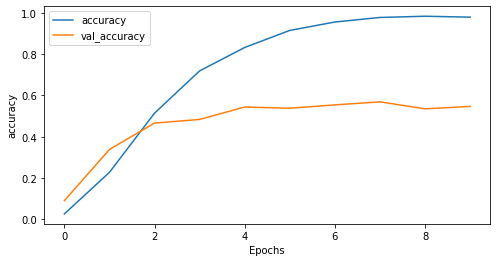

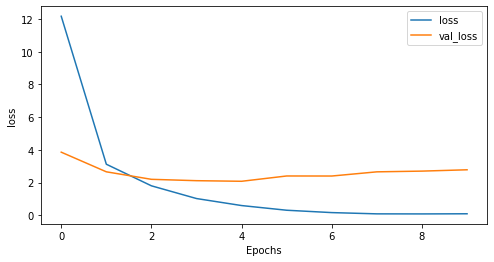

In [25]:
plot_graphs(logs[MODEL_NAME])

## More complex model
Adding 1 layer with more nodes, changing kernel size

In [164]:
model2 = Sequential([
    Conv2D(16, padding='same', kernel_size=(7,7), activation='relu', input_shape=img_shape),
    MaxPooling2D(padding='same'),
    Conv2D(32, kernel_size=(5,5), activation='relu'),
    MaxPooling2D(),
    Conv2D(64, kernel_size=(5,5), activation='relu'),
    MaxPooling2D(),
    Conv2D(128, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
  )

model2.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_69 (Conv2D)          (None, 90, 120, 16)       800       
                                                                 
 max_pooling2d_74 (MaxPoolin  (None, 45, 60, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_70 (Conv2D)          (None, 41, 56, 32)        12832     
                                                                 
 max_pooling2d_75 (MaxPoolin  (None, 20, 28, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_71 (Conv2D)          (None, 16, 24, 64)        51264     
                                                                 
 max_pooling2d_76 (MaxPoolin  (None, 8, 12, 64)      

In [165]:
# fit
MODEL_NAME = 'more_complex'

logs[MODEL_NAME] = model2.fit(
    train_ds,
    validation_data = val_ds,
    epochs = EPOCHS,
)

Epoch 1/10
43/43 [==============================] - 1s 21ms/step - loss: 8.7822 - accuracy: 0.0235 - val_loss: 3.8611 - val_accuracy: 0.0748
Epoch 2/10
43/43 [==============================] - 1s 17ms/step - loss: 3.3292 - accuracy: 0.1613 - val_loss: 2.8504 - val_accuracy: 0.2713
Epoch 3/10
43/43 [==============================] - 1s 17ms/step - loss: 2.3470 - accuracy: 0.3842 - val_loss: 2.1246 - val_accuracy: 0.4370
Epoch 4/10
43/43 [==============================] - 1s 17ms/step - loss: 1.5918 - accuracy: 0.5554 - val_loss: 1.7942 - val_accuracy: 0.5059
Epoch 5/10
43/43 [==============================] - 1s 17ms/step - loss: 1.0187 - accuracy: 0.6987 - val_loss: 1.5579 - val_accuracy: 0.5762
Epoch 6/10
43/43 [==============================] - 1s 17ms/step - loss: 0.6066 - accuracy: 0.8185 - val_loss: 1.5037 - val_accuracy: 0.6246
Epoch 7/10
43/43 [==============================] - 1s 17ms/step - loss: 0.3928 - accuracy: 0.8823 - val_loss: 1.4419 - val_accuracy: 0.6760
Epoch 8/10
43

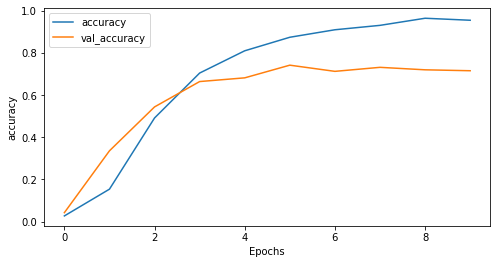

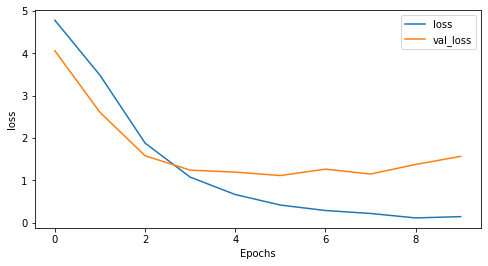

In [41]:
plot_graphs(logs[MODEL_NAME])

## Adding dropout
implies to train for more epochs to reach similar accuracy

In [61]:
model3 = Sequential([
    Conv2D(16, padding='same', kernel_size=(7,7), activation='relu', input_shape=img_shape),
    Dropout(0.4, seed=SEED),
    MaxPooling2D(padding='same'),
    Dropout(0.4, seed=SEED),
    Conv2D(32, kernel_size=(5,5), activation='relu'),
    Dropout(0.5, seed=SEED),
    MaxPooling2D(),
    Dropout(0.4, seed=SEED),
    Conv2D(64, kernel_size=(5,5), activation='relu'),
    MaxPooling2D(),
    Dropout(0.3, seed=SEED),
    Conv2D(128, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(num_classes, activation='softmax')
])


model3.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
  )

In [62]:
MODEL_NAME = 'dropout'
EPOCHS=40

logs[MODEL_NAME] = model3.fit(
    train_ds,
    validation_data = val_ds,
    epochs = EPOCHS,
)

Epoch 1/40
43/43 [==============================] - 2s 27ms/step - loss: 58.5799 - accuracy: 0.0154 - val_loss: 4.1269 - val_accuracy: 0.0117
Epoch 2/40
43/43 [==============================] - 1s 23ms/step - loss: 4.2586 - accuracy: 0.0183 - val_loss: 4.1272 - val_accuracy: 0.0176
Epoch 3/40
43/43 [==============================] - 1s 23ms/step - loss: 4.1242 - accuracy: 0.0191 - val_loss: 4.1265 - val_accuracy: 0.0205
Epoch 4/40
43/43 [==============================] - 1s 23ms/step - loss: 4.0645 - accuracy: 0.0290 - val_loss: 4.1190 - val_accuracy: 0.0323
Epoch 5/40
43/43 [==============================] - 1s 23ms/step - loss: 3.8944 - accuracy: 0.0579 - val_loss: 4.0928 - val_accuracy: 0.0205
Epoch 6/40
43/43 [==============================] - 1s 23ms/step - loss: 3.6980 - accuracy: 0.0905 - val_loss: 4.0811 - val_accuracy: 0.0205
Epoch 7/40
43/43 [==============================] - 1s 22ms/step - loss: 3.5707 - accuracy: 0.1147 - val_loss: 4.0155 - val_accuracy: 0.0674
Epoch 8/40
4

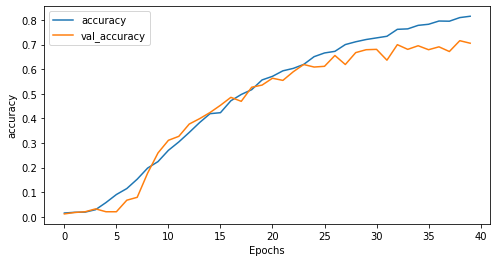

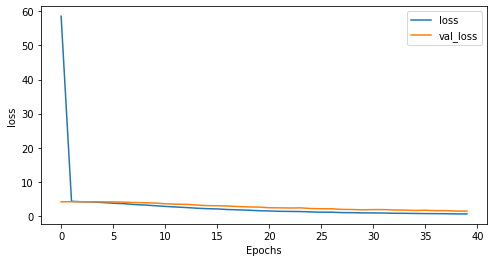

In [63]:
plot_graphs(logs[MODEL_NAME])

## Data augmentation

In [64]:
data_augmentation = Sequential(
  [
    GaussianNoise(0.3, seed=SEED),
    RandomRotation((-0.1, 0.1), seed=SEED),
    RandomZoom(0.1, 0.1,  seed=SEED),
  ]
)

model4 = Sequential([
    data_augmentation,
    tf.keras.models.clone_model(model3)
])

model4.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
  )


In [66]:
MODEL_NAME = 'data_augmentation'

EPOCHS=80
logs[MODEL_NAME] = model4.fit(
    train_ds,
    validation_data = val_ds,
    epochs = EPOCHS
)

Epoch 1/80
43/43 [==============================] - 1s 25ms/step - loss: 4.4157 - accuracy: 0.0205 - val_loss: 4.1261 - val_accuracy: 0.0161
Epoch 2/80
43/43 [==============================] - 1s 24ms/step - loss: 4.1876 - accuracy: 0.0158 - val_loss: 4.1261 - val_accuracy: 0.0220
Epoch 3/80
43/43 [==============================] - 1s 24ms/step - loss: 4.1216 - accuracy: 0.0187 - val_loss: 4.1267 - val_accuracy: 0.0117
Epoch 4/80
43/43 [==============================] - 1s 24ms/step - loss: 4.0971 - accuracy: 0.0235 - val_loss: 4.1258 - val_accuracy: 0.0191
Epoch 5/80
43/43 [==============================] - 1s 24ms/step - loss: 4.0642 - accuracy: 0.0275 - val_loss: 4.1266 - val_accuracy: 0.0191
Epoch 6/80
43/43 [==============================] - 1s 24ms/step - loss: 3.9730 - accuracy: 0.0385 - val_loss: 4.0993 - val_accuracy: 0.0337
Epoch 7/80
43/43 [==============================] - 1s 24ms/step - loss: 3.8425 - accuracy: 0.0594 - val_loss: 4.0617 - val_accuracy: 0.0513
Epoch 8/80
43

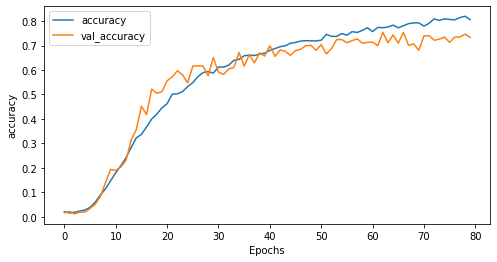

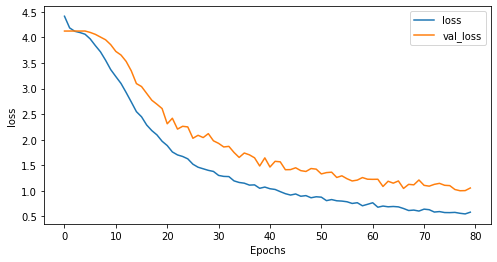

In [67]:
plot_graphs(logs[MODEL_NAME])

## Adjusting learning rate 
adding callbacks to adjust learning rate and do early stopping

In [140]:
# early stopping
cb_EarlyStopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=1e-4,
    patience=10,
    verbose=1,
    restore_best_weights=True,
)

# learning rate scheduler
def scheduler(epoch, lr):
  if epoch < 10:
    return lr-0.0001
  if epoch < 50:
    return lr
  else:
    return lr * tf.math.exp(-0.0005*epoch)

cb_LRScheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [141]:
model5=tf.keras.models.clone_model(model4)
MODEL_NAME = 'adjusted_learning_rate'
learning_rate=2e-3
model5.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
  )

EPOCHS=120

logs[MODEL_NAME] = model5.fit(
    train_ds,
    validation_data = val_ds,
    epochs = EPOCHS,
    callbacks=[cb_EarlyStopping, cb_LRScheduler]
)

Epoch 1/120
43/43 [==============================] - 2s 28ms/step - loss: 39.9313 - accuracy: 0.0147 - val_loss: 4.1286 - val_accuracy: 0.0191 - lr: 0.0019
Epoch 2/120
43/43 [==============================] - 1s 23ms/step - loss: 4.1295 - accuracy: 0.0180 - val_loss: 4.1297 - val_accuracy: 0.0117 - lr: 0.0018
Epoch 3/120
43/43 [==============================] - 1s 23ms/step - loss: 4.1269 - accuracy: 0.0194 - val_loss: 4.1310 - val_accuracy: 0.0117 - lr: 0.0017
Epoch 4/120
43/43 [==============================] - 1s 23ms/step - loss: 4.1275 - accuracy: 0.0154 - val_loss: 4.1320 - val_accuracy: 0.0103 - lr: 0.0016
Epoch 5/120
43/43 [==============================] - 1s 23ms/step - loss: 4.1260 - accuracy: 0.0187 - val_loss: 4.1324 - val_accuracy: 0.0059 - lr: 0.0015
Epoch 6/120
43/43 [==============================] - 1s 23ms/step - loss: 4.1219 - accuracy: 0.0198 - val_loss: 4.1321 - val_accuracy: 0.0103 - lr: 0.0014
Epoch 7/120
43/43 [==============================] - 1s 23ms/step - l

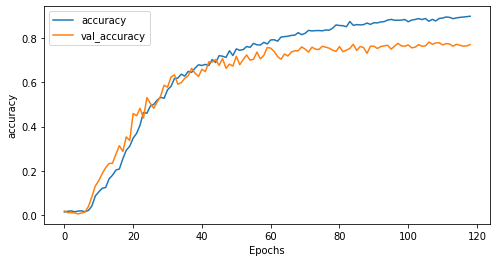

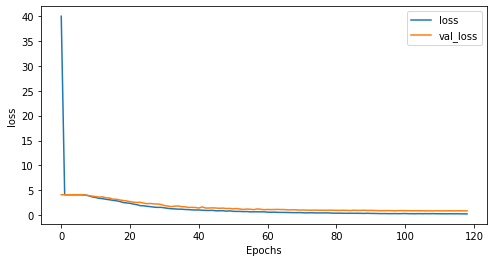

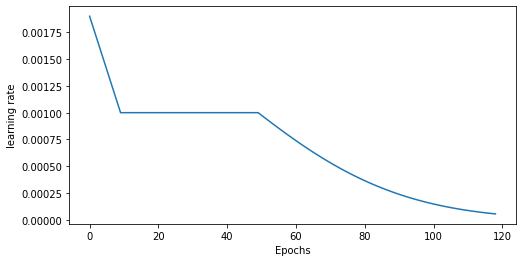

In [142]:
plot_graphs(logs[MODEL_NAME])

plt.figure(figsize=(8, 4))
plt.xlabel("Epochs")
plt.ylabel('learning rate')
plt.plot(logs[MODEL_NAME].history['lr'])
plt.show()

In [143]:
model5.save("model.h5")

Plot wrong predictions

11/11 [==============================] - 0s 7ms/step


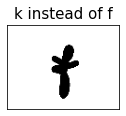

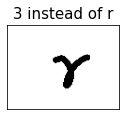

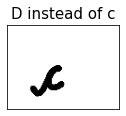

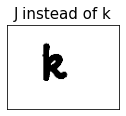

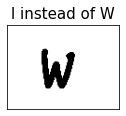

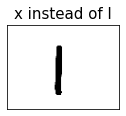

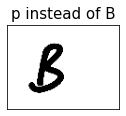

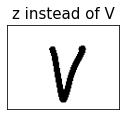

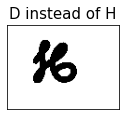

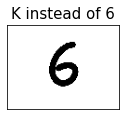

In [144]:
predictions = model5.predict(val_ds)
i=0
for img, label in val_ds:
  if np.argmax(predictions[i]) != label[i]:
    title=int_to_label[np.argmax(predictions[i])] + " instead of " + int_to_label[label.numpy()[i]]
    plot_char(img[i], title)
  i+=1

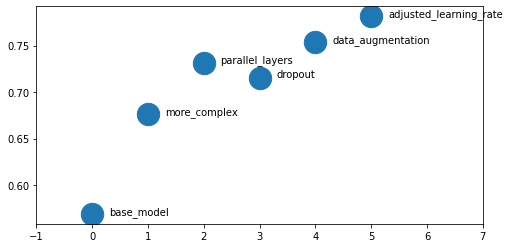

In [213]:
best_accuracies=[]
x=list(range(6))
for key, value in logs.items():
  best_accuracies.append(np.max(value.history['val_accuracy']))

plt.figure(figsize=(8, 4))
plt.scatter(x, best_accuracies, s=500)
plt.xlim([-1, 7])
for i, key in enumerate(logs.keys()):
  plt.annotate(key, (x[i]+0.3, best_accuracies[i]))
plt.show()